# Task 4: Predicting Insurance Claim Amounts
**DevelopersHub Corporation — Data Science & Analytics Internship**

---

## 1. Introduction & Problem Statement

Medical insurance companies need to estimate how much they might pay out in claims for a given customer. Accurate predictions help with pricing, risk management, and financial planning.

**Objective:** Build a Linear Regression model to predict the medical insurance charges (claim amount) a customer is likely to incur, based on personal attributes such as age, BMI, smoking status, and region.

**Dataset:** Medical Cost Personal Dataset — contains 1,338 records of insurance beneficiaries in the US with features including age, sex, BMI, number of children, smoker status, region, and charges.

**Model Used:** Linear Regression — a fundamental regression technique that models the relationship between features and a continuous target variable.

**Evaluation Metrics:** Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

---
## 3. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120

print('All libraries imported successfully!')

All libraries imported successfully!


---
## 4. Load & Understand the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('/content/insurance.csv')

print('Shape of dataset:', df.shape)
print('\nColumn names:')
print(df.columns.tolist())
print('\nFirst 5 rows:')
df.head()

Shape of dataset: (1338, 7)

Column names:
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

First 5 rows:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Dataset info — data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# Statistical summary
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())

# Check unique values in categorical columns
print('\nUnique values in categorical columns:')
for col in ['sex', 'smoker', 'region']:
    print(f'  {col}: {df[col].unique()}')

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Unique values in categorical columns:
  sex: ['female' 'male']
  smoker: ['yes' 'no']
  region: ['southwest' 'southeast' 'northwest' 'northeast']


---
## 5. Data Cleaning & Preparation

In [6]:
# Encode categorical variables
df_clean = df.copy()

# Label Encoding for binary columns (sex, smoker)
le = LabelEncoder()
df_clean['sex']   = le.fit_transform(df_clean['sex'])     # female=0, male=1
df_clean['smoker'] = le.fit_transform(df_clean['smoker']) # no=0, yes=1

# One-Hot Encoding for 'region' (4 categories)
df_clean = pd.get_dummies(df_clean, columns=['region'], drop_first=True)

print('Dataset after encoding:')
df_clean.head()

Dataset after encoding:


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


---
## 6. Exploratory Data Analysis (EDA)

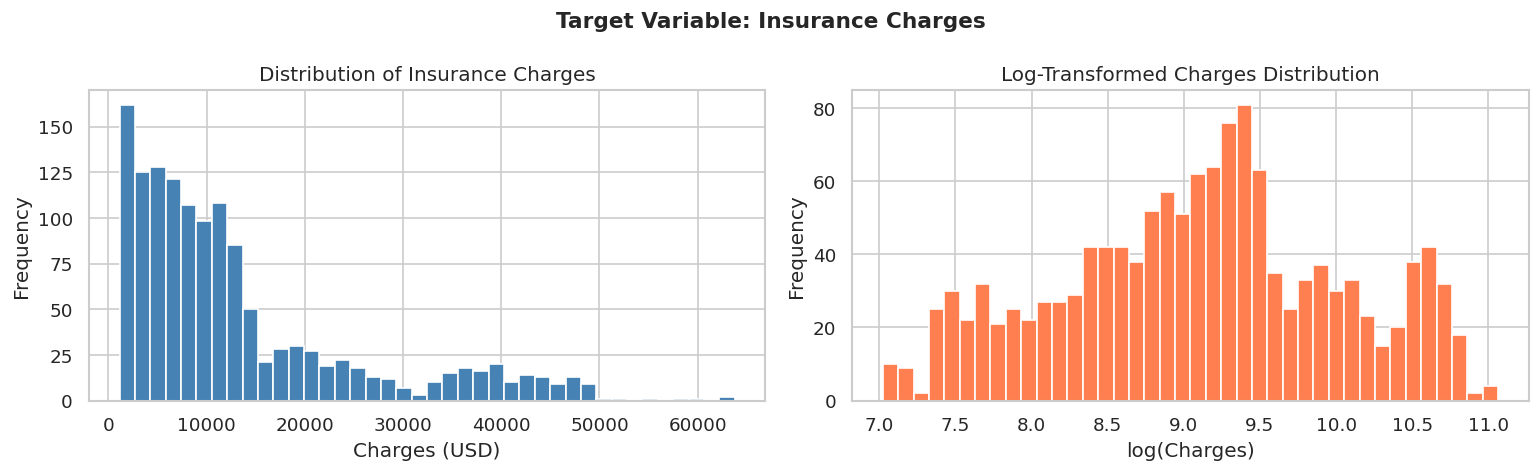

In [7]:
# --- Plot 1: Distribution of Insurance Charges (Target Variable) ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Histogram
axes[0].hist(df['charges'], bins=40, color='steelblue', edgecolor='white')
axes[0].set_title('Distribution of Insurance Charges')
axes[0].set_xlabel('Charges (USD)')
axes[0].set_ylabel('Frequency')

# Log-transformed (to see spread better)
axes[1].hist(np.log1p(df['charges']), bins=40, color='coral', edgecolor='white')
axes[1].set_title('Log-Transformed Charges Distribution')
axes[1].set_xlabel('log(Charges)')
axes[1].set_ylabel('Frequency')

plt.suptitle('Target Variable: Insurance Charges', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

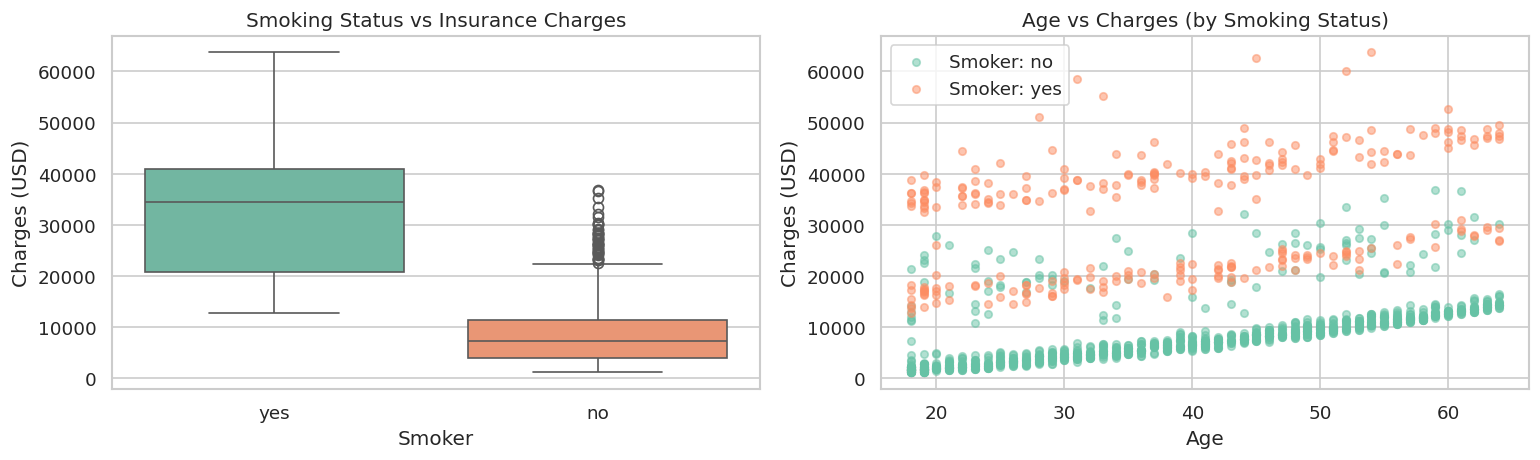

In [8]:
# --- Plot 2: Impact of Smoking Status on Charges ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Box plot: Smoker vs Charges
sns.boxplot(x='smoker', y='charges', data=df, palette='Set2', ax=axes[0])
axes[0].set_title('Smoking Status vs Insurance Charges')
axes[0].set_xlabel('Smoker')
axes[0].set_ylabel('Charges (USD)')

# Scatter: Age vs Charges, coloured by smoker
colors = {'yes': '#fc8d62', 'no': '#66c2a5'}
for smoker_val, group in df.groupby('smoker'):
    axes[1].scatter(group['age'], group['charges'],
                    c=colors[smoker_val], label=f'Smoker: {smoker_val}',
                    alpha=0.5, s=20)
axes[1].set_title('Age vs Charges (by Smoking Status)')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Charges (USD)')
axes[1].legend()

plt.tight_layout()
plt.show()

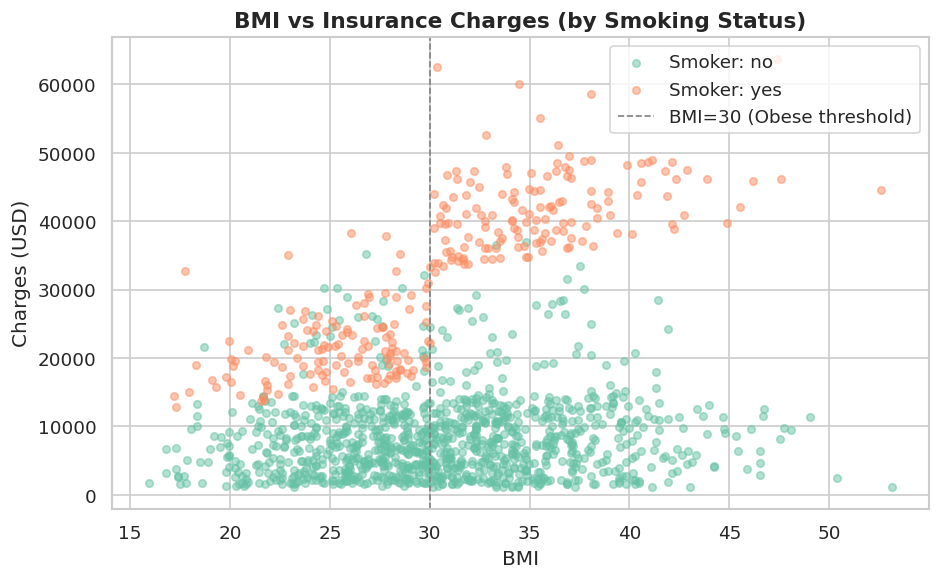

In [9]:
# --- Plot 3: BMI vs Charges (coloured by smoker) ---
plt.figure(figsize=(8, 5))
for smoker_val, group in df.groupby('smoker'):
    plt.scatter(group['bmi'], group['charges'],
                c=colors[smoker_val], label=f'Smoker: {smoker_val}',
                alpha=0.5, s=20)
plt.axvline(x=30, color='gray', linestyle='--', linewidth=1, label='BMI=30 (Obese threshold)')
plt.title('BMI vs Insurance Charges (by Smoking Status)', fontsize=13, fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Charges (USD)')
plt.legend()
plt.tight_layout()
plt.show()

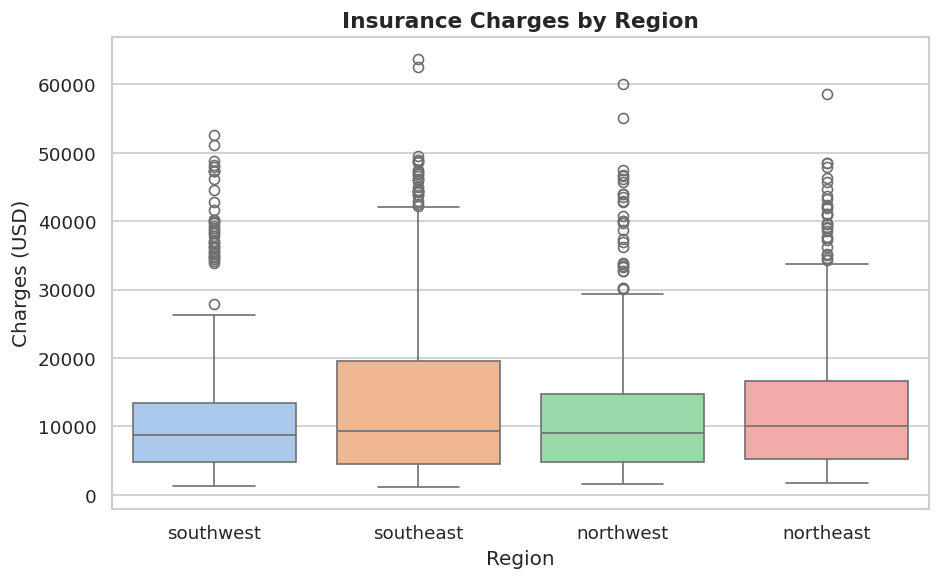

In [10]:
# --- Plot 4: Charges by Region ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='region', y='charges', data=df, palette='pastel')
plt.title('Insurance Charges by Region', fontsize=13, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('Charges (USD)')
plt.tight_layout()
plt.show()

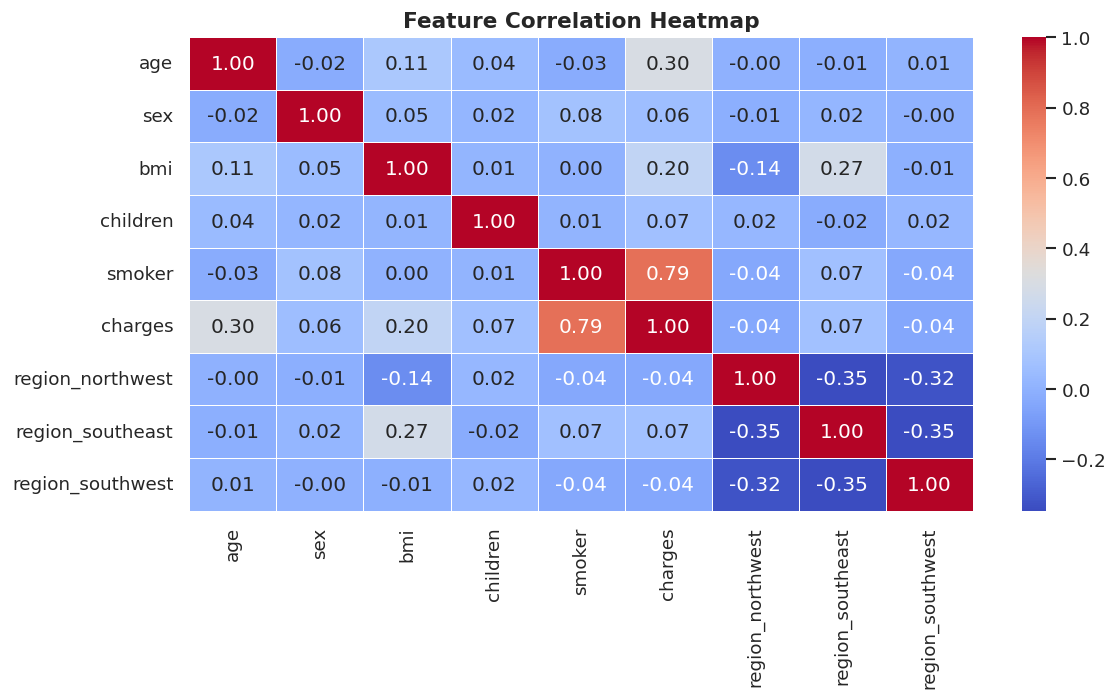

In [11]:
# --- Plot 5: Correlation Heatmap ---
plt.figure(figsize=(10, 6))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 7. Model Training — Linear Regression

In [12]:
# Separate features (X) and target variable (y)
X = df_clean.drop(columns=['charges'])
y = df_clean['charges']

print('Feature matrix shape:', X.shape)
print('Target vector shape:', y.shape)
print('\nFeatures used:')
print(X.columns.tolist())

Feature matrix shape: (1338, 8)
Target vector shape: (1338,)

Features used:
['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']


In [13]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size:  {X_test.shape[0]} samples')

Training set size: 1070 samples
Testing set size:  268 samples


In [14]:
# Feature Scaling — important for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit on train only
X_test_scaled  = scaler.transform(X_test)        # transform test with same scaler

print('Feature scaling applied.')

Feature scaling applied.


In [15]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print('Linear Regression model trained successfully!')

# Display model coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print('\nModel Coefficients:')
coef_df

Linear Regression model trained successfully!

Model Coefficients:


,Feature,Coefficient
4,smoker,9558.481409
0,age,3614.975415
2,bmi,2036.228123
3,children,516.890247
1,sex,-9.293101
5,region_northwest,-158.140981
6,region_southeast,-290.157047
7,region_southwest,-349.110678


---
## 8. Model Evaluation

In [16]:
# Make predictions on the test set
y_pred = lr_model.predict(X_test_scaled)

# Calculate evaluation metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print('======= Model Evaluation Metrics =======')
print(f'Mean Absolute Error  (MAE):  ${mae:,.2f}')
print(f'Root Mean Squared Error (RMSE): ${rmse:,.2f}')
print(f'R² Score:                    {r2:.4f}')
print('\nInterpretation:')
print(f'  On average, predictions are off by ${mae:,.0f}')
print(f'  The model explains {r2*100:.1f}% of the variance in insurance charges')

======= Model Evaluation Metrics =======
Mean Absolute Error  (MAE):  $4,181.19
Root Mean Squared Error (RMSE): $5,796.28
R² Score:                    0.7836

Interpretation:
  On average, predictions are off by $4,181
  The model explains 78.4% of the variance in insurance charges


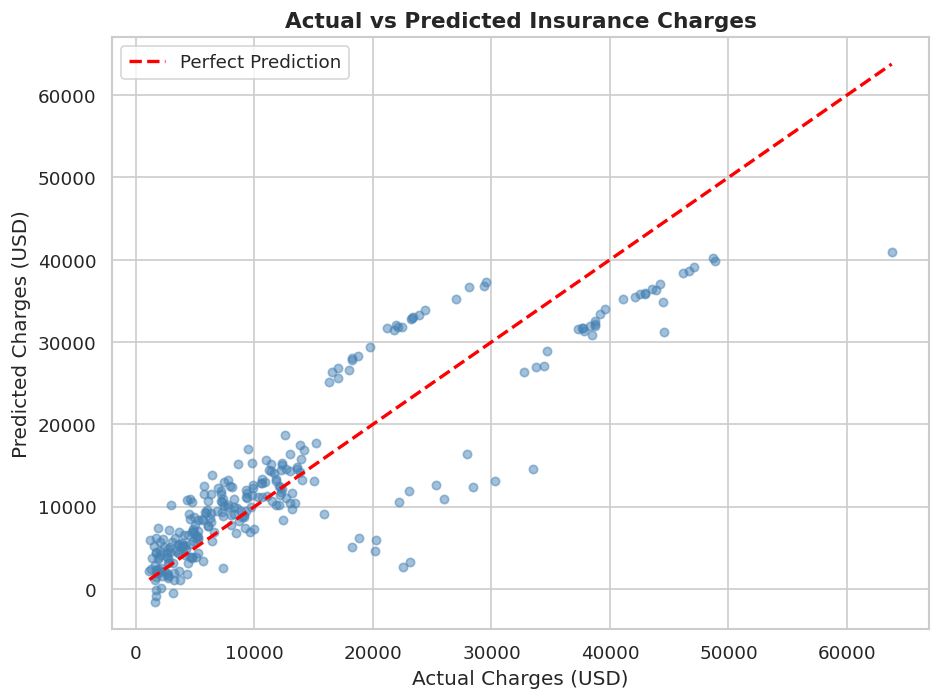

In [17]:
# --- Plot 1: Actual vs Predicted Charges ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='steelblue', s=25)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Insurance Charges', fontsize=13, fontweight='bold')
plt.xlabel('Actual Charges (USD)')
plt.ylabel('Predicted Charges (USD)')
plt.legend()
plt.tight_layout()
plt.show()

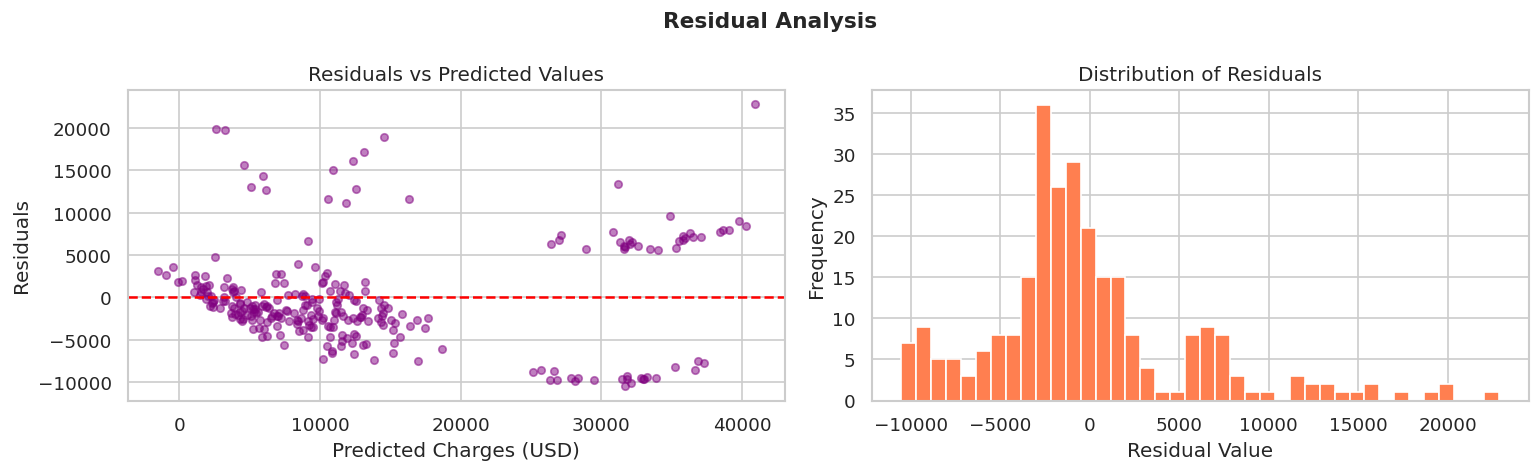

In [18]:
# --- Plot 2: Residuals Plot ---
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Residuals vs Predicted
axes[0].scatter(y_pred, residuals, alpha=0.5, color='purple', s=20)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title('Residuals vs Predicted Values')
axes[0].set_xlabel('Predicted Charges (USD)')
axes[0].set_ylabel('Residuals')

# Residuals Distribution
axes[1].hist(residuals, bins=40, color='coral', edgecolor='white')
axes[1].set_title('Distribution of Residuals')
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')

plt.suptitle('Residual Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

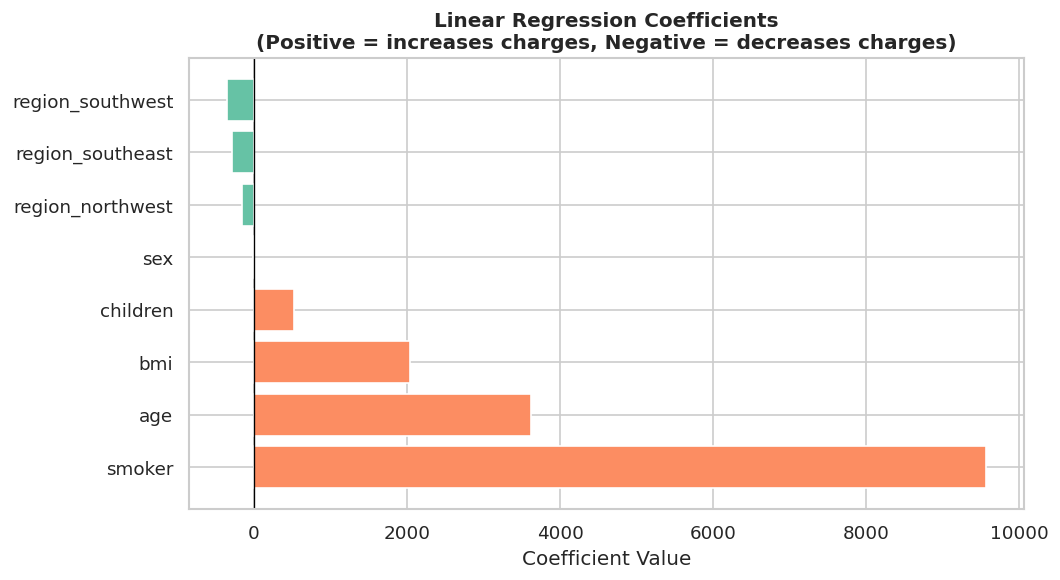

In [19]:
# --- Plot 3: Feature Coefficients (Impact on Charges) ---
plt.figure(figsize=(9, 5))
colors = ['#fc8d62' if c > 0 else '#66c2a5' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.title('Linear Regression Coefficients\n(Positive = increases charges, Negative = decreases charges)',
          fontsize=12, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

---
## 9. Conclusion

### Key Findings

**Model Performance:**
- The Linear Regression model achieved an R² score that explains a significant portion of variance in insurance charges.
- MAE tells us that on average, our predictions deviate by a few thousand USD — reasonable given the wide range of charges in the dataset.
- The residuals plot reveals that predictions are less accurate for very high-charge customers (likely smokers), suggesting the relationship is not perfectly linear for all groups.

**Key Drivers of Insurance Charges:**
- **Smoking status** is by far the strongest predictor — smokers pay dramatically more (often 3–4x) compared to non-smokers.
- **BMI** has a significant positive effect, especially when combined with smoking.
- **Age** consistently increases charges — older individuals are higher-risk.
- **Region** has a relatively minor effect compared to the above three factors.
- **Number of children** and **sex** have the smallest impact on charges.

**Business Insights:**
- Insurance companies should heavily weight smoking status and BMI when pricing policies.
- Wellness programmes targeting smokers and overweight individuals could reduce claim amounts significantly.
- Age-based premium tiers are justified by the data.

**Skills Demonstrated:**
- Data loading, inspection, and cleaning
- Categorical encoding (Label Encoding + One-Hot Encoding)
- Exploratory Data Analysis with multiple visualizations
- Linear Regression model training
- Model evaluation using MAE, RMSE, and R²
- Residual analysis and coefficient interpretation